# Learing pipeline

Miguel Xochicale [@mxochicale](https://github.com/mxochicale)  
Feb2022


## 1.1 Introduction
This notebook presents prototypes to pre-process echocardiography datasets with the use of pytorch features. 

## 1.2 Running notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
## 1.3 References
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 




## 2. Jupyter Notebook

### 2.1 Setting imports and datasets paths

In [70]:
import os
import sys
import argparse
import yaml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())

from torch.utils.data import DataLoader
from torchvision import transforms, utils

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.models.nets_misc import SimpleVideoClassifier, train_loop, test_loop
from source.helpers.various import concatenating_YAML_via_tags, plot_dataset_classes

HOME_PATH = os.path.expanduser(f'~')
CONFIG_FILES_PATH= 'repositories/echocardiography/scripts/config_files/learning_pipeline'
YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, 'config_learning_pipeline.yml')

yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler

with open(YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)

### 2.2 Setting variables and loading datasets using pytorch dataloader

In [71]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_im_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=config['pretransform_im_size']),
        transforms.ToTensor(),
    ])
else:
    pretransform = None

# Defiining some transforms for data augmentation: 
# These transforms have random parameters that will change at each epoch.
if config['use_augmentation']:
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),  # this normalizes in
    ])
else:
    transform = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list'],
    participant_path_json_list=config['participant_path_json_list'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=transform,
    use_tmp_storage=True,
    )

print(f'Number of total clips: {len(dataset)} ')
labelnames = ('BKGR', '4CV')
for clip_index_i in range(len(dataset)):
    data_idx = dataset[clip_index_i]
    print(f'   Clip number: {clip_index_i}; Label: {labelnames[data_idx[1]]}   Random index in the segment clip: {data_idx[2]}             of n_available_frames {data_idx[3]}')



Number of total clips: 18 
   Clip number: 0; Label: BKGR   Random index in the segment clip: 0             of n_available_frames 70
   Clip number: 1; Label: BKGR   Random index in the segment clip: 85             of n_available_frames 151
   Clip number: 2; Label: BKGR   Random index in the segment clip: 78             of n_available_frames 150
   Clip number: 3; Label: BKGR   Random index in the segment clip: 0             of n_available_frames 79
   Clip number: 4; Label: BKGR   Random index in the segment clip: 0             of n_available_frames 83
   Clip number: 5; Label: BKGR   Random index in the segment clip: 78             of n_available_frames 150
   Clip number: 6; Label: BKGR   Random index in the segment clip: 62             of n_available_frames 151
   Clip number: 7; Label: BKGR   Random index in the segment clip: 78             of n_available_frames 150
   Clip number: 8; Label: BKGR   Random index in the segment clip: 66             of n_available_frames 150
   Clip

### 2.3 Animating frames in the dataloader

Clip Size of data_clip_idx torch.Size([90, 1, 128, 128]) 


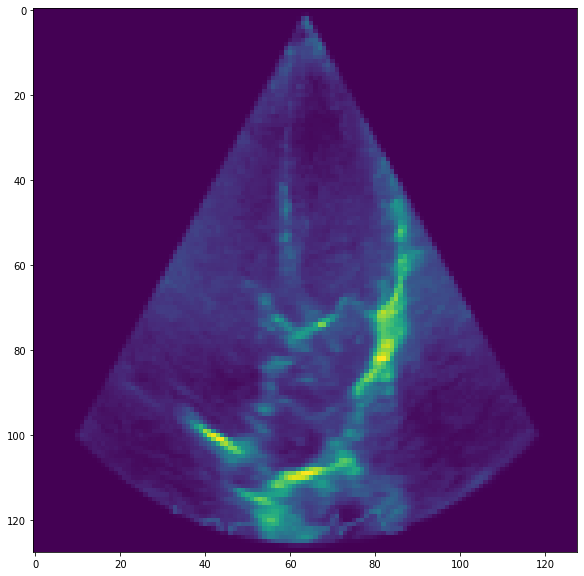

In [80]:
#average_HR =
#fps = 30
# 60 # beats per minute 
#Beats-per-minute: 60 BPM
#Beats-per-second: 1 Hz
#Cycle-per-second: 1 (Cycle/s)

clip_idx = 12
data_clip_idx = dataset[clip_idx][0]
data_clip_label = dataset[clip_idx][1]
print(f'Clip Size of data_clip_idx {data_clip_idx.size()} ')

### Animating data_clip_idx 
interval_between_frames_in_milliseconds=200
fig = plt.figure(figsize=(10, 10))
frames = [[plt.imshow(data_clip_idx[i].cpu().detach().numpy().transpose(1, 2, 0))] for i in range(len(data_clip_idx))]
anim = animation.ArtistAnimation(fig, frames, interval=interval_between_frames_in_milliseconds, blit=True, repeat_delay=1000)

HTML(anim.to_jshtml())

# ### Save animation as gif (if required) or other formats https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/
# f = r"/home/mx19/repositories/echocardiography/scripts/learning-pipeline/animation.gif" 
# writergif = animation.PillowWriter(fps=30) 
# writergif2='imagemagick'
# anim.save(f, dpi=80, writer=writergif)


### 2.4 Displayting frames in the dataloader

Number of batches: 1 
       ----------------------------------------------------------
       batch_index: 0 batch_size: torch.Size([90, 1, 128, 128])
       Grid size torch.Size([3, 1562, 1042])


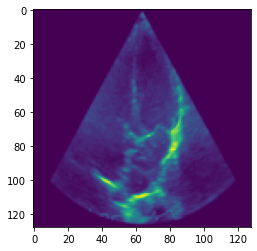

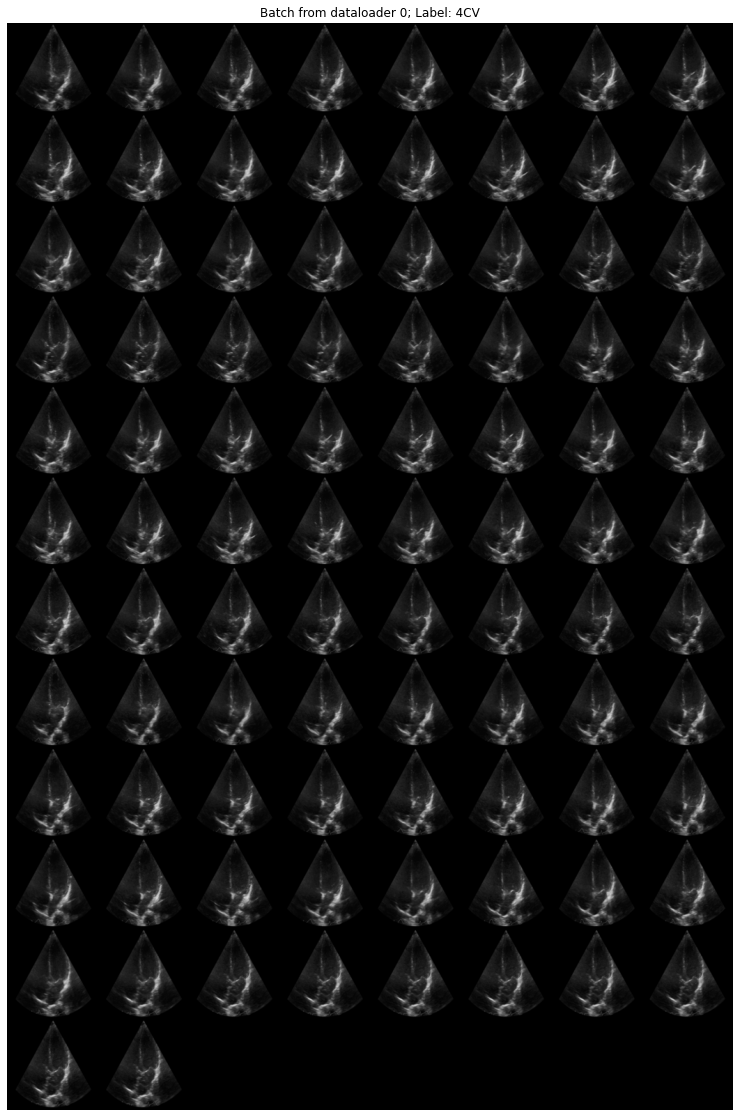

In [79]:

##Batch size is the number of frames for one segment and those frames can be set to suffle 
dataloader = DataLoader(
    data_clip_idx,
    batch_size=90,
    shuffle=False,
    num_workers=0,
    pin_memory=False
    )
length_of_dl=len(dataloader)
print(f'Number of batches: {length_of_dl} ')


for i_batch, sample_batched in enumerate(dataloader):
    print(f'       ----------------------------------------------------------')
    print(f'       batch_index: {i_batch} batch_size: {sample_batched.size()}')
    
    #print( len(sample_batched) )
    frames = [[plt.imshow(sample_batched[i].cpu().detach().numpy().transpose(1, 2, 0) )] for i in range(len(sample_batched))]
    ani = animation.ArtistAnimation(fig, frames)
    ani

    plt.figure(figsize =(20,20) )
    plt.tight_layout()
    grid = utils.make_grid(sample_batched)
    print(f'       Grid size {grid.size()}' )
    plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
    plt.title(f'Batch from dataloader {i_batch}; Label: {labelnames[data_clip_label]}')
    plt.axis('off')
    plt.ioff()
    plt.show()

    


In [81]:
print(f'Loaded EchoClassesDataset with {len(dataset)} clips ')
data_clip00 = dataset[0]
train_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=config['batch_size'], shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=config['batch_size'], shuffle=True)
print(type(train_dataloader))

## Setting up model
data_size = tuple(data_clip00[0].shape)
print(type(data_size))
print(data_size)
model_net = SimpleVideoClassifier(data_size)
model_net.to(device)
print(model_net)

optimizer = torch.optim.Adam(model_net.parameters())  # use default settings
loss_function = torch.nn.CrossEntropyLoss()

for epoch in range(config['max_epochs']):
    print(f'Epoch {epoch + 1}\n-------------------------------')
    train_loop(train_dataloader, model_net, loss_function, optimizer, device)
    test_loop(test_dataloader, model_net, loss_function, device)

print(f'Done!')


Loaded EchoClassesDataset with 18 clips 
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'tuple'>
(90, 1, 128, 128)
SimpleVideoClassifier(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1474560, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=2, bias=True)
    (4): Sigmoid()
  )
)
Epoch 1
-------------------------------
loss: 0.700592
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 2
-------------------------------
loss: 0.813262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.688262 

Epoch 3
-------------------------------
loss: 0.563262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 4
-------------------------------
loss: 0.813262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 5
-------------------------------
loss: 0.938262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.688262 

Epoch 6
-------------------------------
loss: 0.938262
Test Error: 
 Accuracy: 50.0

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 75
-------------------------------
loss: 0.688262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 76
-------------------------------
loss: 0.938262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.938262 

Epoch 77
-------------------------------
loss: 0.813262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 78
-------------------------------
loss: 0.688262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.688262 

Epoch 79
-------------------------------
loss: 0.688262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 80
-------------------------------
loss: 0.938262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.938262 

Epoch 81
-------------------------------
loss: 0.813262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 82
-------------------------------
loss: 0.688262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 83
-------------------------------
loss: 0.813262
Test Error: 
 Accuracy: 50.0

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.938262 

Epoch 151
-------------------------------
loss: 0.438262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 152
-------------------------------
loss: 0.938262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 153
-------------------------------
loss: 0.938262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 154
-------------------------------
loss: 0.688262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 155
-------------------------------
loss: 0.688262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 156
-------------------------------
loss: 1.063262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.938262 

Epoch 157
-------------------------------
loss: 1.188262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 158
-------------------------------
loss: 0.938262
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.813262 

Epoch 159
-------------------------------
loss: 0.688262
Test Error: 
 Accur